## Disentangling infection-induced changes in the single-cell atlas of the *Plasmodium* liver stage (Part II)

This is the second part of our tutorial on learning infection-related representations in the single-cell atlas of the *Plasmodium* liver stage. 

Recap of the first part:

* We demonstrate the utility of linear PCA-based models, including the newly introduced `sisPCA` model, to learn interpretable subspaces for direct infection and post-infection temporal dynamics. 
* Using the projection matrix (i.e. PCA loading), we identify genes and functional pathways that are most associated with parasite harboring and/or post-infection dynamics.
* We discuss and propose an automatic pipelin for the selection of model hyperparameter `lambda_contrast`.

In this second part, we will now consider non-linear variational autoencoder (VAE) counterparts of `PCA`, `sPCA`, and `sisPCA` to learn infection-related representations in the scRNA-seq data. Those VAE models are inspired by the work of [HCV from "Information Constraints on Auto-Encoding Variational Bayes" (Lopez et al. 2018)](https://proceedings.neurips.cc/paper_files/paper/2018/file/9a96a2c73c0d477ff2a6da3bf538f4f4-Paper.pdf) and are re-implemented using the [scvi package](https://scvi-tools.org/). 

To run this tutorial, make sure you have the following [scverse](https://scverse.org/packages/#core-packages) packages installed. The versions of the packages used in this tutorial are:

- `scanpy`: v1.10.3
- `scvi-tools`: v1.2.0

In [1]:
import torch
from lightning.pytorch import seed_everything

torch.set_default_dtype(torch.float32)

import numpy as np
import pandas as pd
from sklearn.metrics import silhouette_score
from scipy.linalg import subspace_angles
import matplotlib.pyplot as plt
from plotnine import *

import scanpy as sc

from sispca.hcv_vi import SupervisionAnnData, HCVI

### Load the infection scRNA-seq anndata
The single-cell atlas of the *Plasmodium* liver stage provides the gene expression profiles of mouse hepatocytes during malaria infection [(Afriat et al. 2022)](https://www.nature.com/articles/s41586-022-05406-5). Pre-processed data can be downloaded from [figshare (from Piran et al. 2024)](https://figshare.com/articles/dataset/spatio-temporal-infection_infected/22148900?file=39375713), and the original dataset is available (as processed Seurat object) at [Zenodo](https://zenodo.org/records/7081863).

Here, we will focus on the log-normalized gene expression counts (`X`) with 19,053 cells (rows) and 8,203 genes (columns). The dataset also contains the following metadata (supervision):

- `Y_time`: the post-infection time point of the sample collection (2, 12, 24, 30 and 36h post-infection, abbreviated hpi, or 'control' for samples from control mice)
- `Y_infected`: The infection status (i.e., whether a hepatocyte contains a parasite) determined based on GFP expression linked to malaria.

The goals of this example analysis are to:

1. Learn separate subspace representations corresponding to the infection status and temporal dynamics after infection,
2. Understand how the gene expression profiles of hepatocytes contribute to infection response and dynamics.

In [2]:
data_dir = "/Users/jysumac/Projects/CancerAging/data/liver_infection/"

data_infected = sc.read_h5ad(data_dir + 'adata_infected.h5ad')
data_infected

AnnData object with n_obs × n_vars = 19053 × 8203
    obs: 'barcode', 'mouse', 'marker', 'time', 'infected', 'experiment', 'coarse_time', 'MB', 'eta', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'mt_qc', 'SUMPBA', 'n_counts', 'n_genes', 'mus_rRNA', 'pba_rRNA', 'pba_rRNA_fraction', 'nCount_PBA', 'nFeature_PBA', 'nCount_MUS', 'nFeature_MUS', 'RNA_snn_res.0.2', 'seurat_clusters', 'MBinfected', 'cluster_names', 'ident', 'eta_normalized', 'nCounts_tot', 'normalized_PBA', 'coarse_time_orig', 'zone', 'status', 'status_control', 'time_int', 'split_random'
    var: 'org', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'coarse_time_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'status_colors', 'status_control_colors', 'umap', 'zone_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'logcounts', 'scaledata'
    obsp: 'connectivities', 'distances'

In [3]:
y_time = data_infected.obs['coarse_time'].cat.codes.to_numpy()[:, None]
y_infected = data_infected.obs['infected'].cat.codes.to_numpy()[:, None]

Let's take a look at the structure of the dataset. Visually we can that the PCA (and UMAP) space contain multiple sources of variation, including the infection status, the time point of the sample collection, and cell intrinsic qualities.

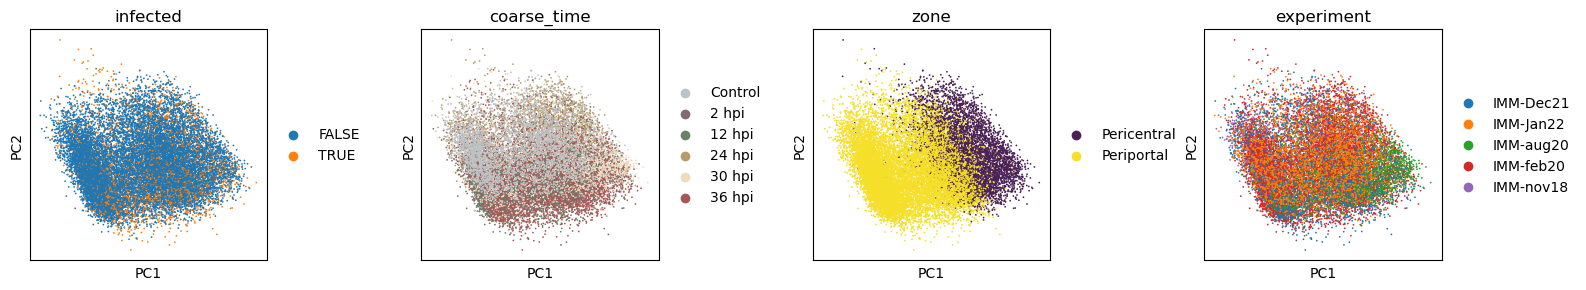

In [4]:
with plt.rc_context({"figure.figsize": (3, 3)}):
    sc.pl.pca(data_infected, color = ['infected', 'coarse_time', 'zone', 'experiment'], wspace=0.5)

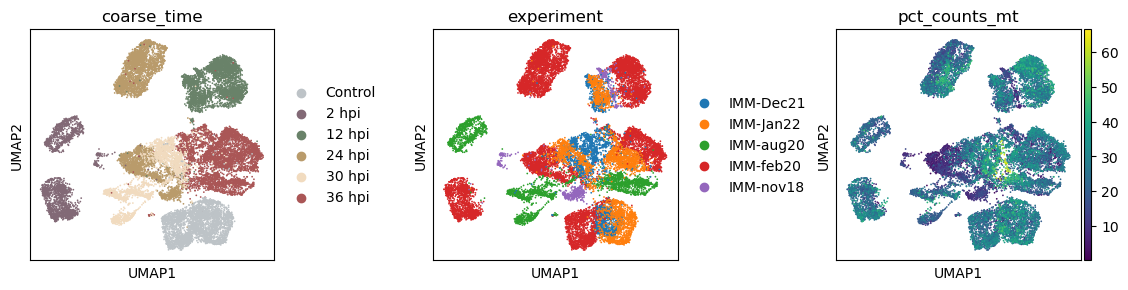

In [5]:
with plt.rc_context({"figure.figsize": (3, 3)}):
    sc.pl.umap(data_infected, color = ['coarse_time', 'experiment', 'pct_counts_mt'], wspace = 0.5)

Before running the PCA and VAE models, the common practice in single-cell analysis is to reduce the number of features (genes) by selecting the most variable genes. Here, we will use the `scanpy.pp.highly_variable_genes` function to select the top 2,000 highly variable genes.

In [6]:
adata = data_infected.copy()

# keep highly variable genes
sc.pp.highly_variable_genes(adata, layer='logcounts', n_top_genes=2000, subset=True)

adata.shape

(19053, 2000)

### Overview of VAE-based non-linear models

Now let's try VAE baseline models (implemented through `scvi-tools`) to recover meaningful subspaces in the scRNA-seq data. These models are inspired by and generally follow the design of the `scVIGenQCModel` from the [HCV paper (Lopez et al. 2018)](https://github.com/romain-lopez/HCV/blob/master/scVI/scVIgenqc.py). In particular, we design three models as the non-linear counterparts of PCA, sPCA, and sisPCA:

- `VAE`: The vanilla unsupervised VAE model. The architecture is the same as the [default SCVI model](https://docs.scvi-tools.org/en/stable/api/reference/scvi.model.SCVI.html) except we set the generative distribution to Gaussian to adapt for log-normalized gene expression.
- `supVAE`: Supervised VAE with additional supervised predictors that predict target variables from the corresponding latent subspaces.
- `hsVAE`: Supervised VAE with additional HSIC-based regularizers that enforce independence between the latent subspaces.

Following HCV and more recent SCVI models, we further implement a domain-specific extension of hsVAE taylored for scRNA-seq data, `hsVAE-sc`, which uses negative binomial as the data generative distribution, has additional parametrization (and prior, encoder) for the library size, and was correspondingly trained on counts-level data. While the `hsVAE-sc` model represents the state-of-the-art in our quantitative analysis, it still lacks interpretability necessary for the biological analysis. We will see this limitation in the next section on PCA-based linear models.

### Run VAE (no supervision, no HSIC regularization)

Let's start with the vanilla `VAE` model. Similar to `PCA`, it is also unsupervised, therefore we will only get one subspace containing all structures.

In [7]:
# specify the configuration
target_supervision_list = None
n_latent_sub = [10]
predict_target_from_latent_sub = False
hsic_scale = 0

seed_everything(42, workers=True)

# initialize the model
HCVI.setup_anndata(adata, layer = 'logcounts', target_supervision_list = target_supervision_list)
vae = HCVI(
    adata, 
    hsic_scale=hsic_scale,
    n_latent_sub=n_latent_sub, 
    predict_target_from_latent_sub=predict_target_from_latent_sub,
    target_supervision_list=target_supervision_list,
)

vae

Seed set to 42
/Users/jysumac/miniforge3/envs/sispca/lib/python3.10/site-packages/scvi/data/fields/_base_field.py:63: UserWarning: adata.layers[logcounts] does not contain unnormalized count data. Are you sure this is what you want?
/Users/jysumac/Projects/sispca/sispca/hcv_vi.py:89: UserWarning: Removing redundant argument 'n_latent=10'.
/Users/jysumac/Projects/sispca/sispca/hcv_vi.py:89: UserWarning: Removing redundant argument 'latent_distribution=normal'.
/Users/jysumac/Projects/sispca/sispca/hcv_vi.py:89: UserWarning: Removing redundant argument 'dispersion=gene'.


HCVI model with the following parameters: 
------------------------------------------
*(architecture): n_layers = 1, dropout_rate = 0.1, gene_likelihood = normal
*(subspace) n_subspace = 1, n_latent_sub = [10], hsic_scale = 0
*(supervision) predict_target = False, n_target = 0
Training status: Not Trained
Model's adata is minified?: False

#### Model fitting

In [8]:
vae.train(max_epochs=100)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/jysumac/miniforge3/envs/sispca/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: PossibleUserWarning: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/jysumac/miniforge3/envs/sispca/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: PossibleUserWarning: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


We can first check the convergence of the model by plotting the training loss. Since there are no supervision and HSIC regularization, the corresponding losses will be zero.

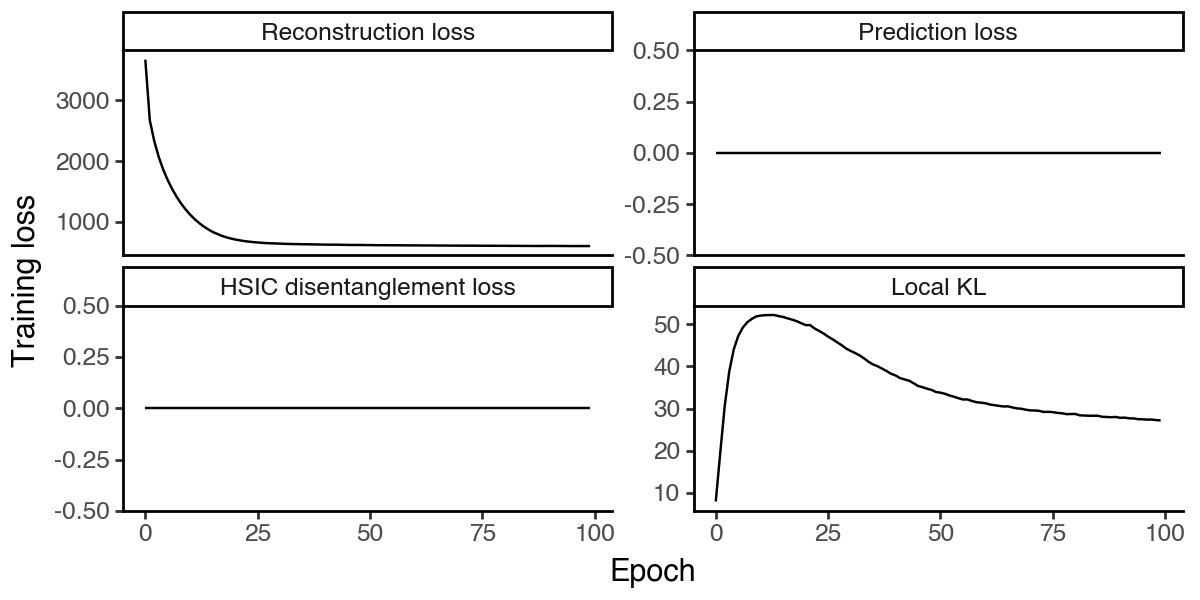

In [9]:
df_loss = pd.DataFrame(
    {k:vae.history[k].values.squeeze().astype(float)
     for k in ['reconstruction_loss_train', 'kl_local_train', 'kl_global_train', 'prediction_loss_sum_train']}
).reset_index(names='epoch')

df_loss = df_loss.melt(id_vars='epoch', var_name='loss_type', value_name='loss')
df_loss['loss_type'] = pd.Categorical(
    df_loss['loss_type'].map({
        'reconstruction_loss_train': 'Reconstruction loss',
        'kl_local_train': 'Local KL',
        'kl_global_train': 'HSIC disentanglement loss',
        'prediction_loss_sum_train': 'Prediction loss'
    }),
    categories=['Reconstruction loss', 'Prediction loss', 'HSIC disentanglement loss', 'Local KL'],
    ordered=True
)

(
    ggplot(df_loss, aes(x = 'epoch', y = 'loss', group = 'loss_type')) +
        facet_wrap('~loss_type', scales='free_y') +
        geom_line() +
        labs(x = 'Epoch', y = 'Training loss') +
        theme_classic() +
        theme(figure_size=(6, 3))
)

#### Visualize the latent subspace

Now let's extract the learned latent subspace and use UMAP to visualize it.

In [10]:
_method = 'vae'
adata.obsm[f'X_{_method}'] = vae.get_latent_representation()

# add the latent representation to the adata object
_sub = np.split(adata.obsm[f'X_{_method}'], n_latent_sub[:-1], axis = -1)
for i in range(len(_sub)):
    adata.obsm[f'X_{_method}_{i+1}'] = _sub[i]

# project the latent subspaces to 2D using UMAP
for i in range(len(_sub)):
    sc.pp.neighbors(adata, use_rep=f"X_{_method}_{i+1}")
    sc.tl.umap(adata)
    adata.obsm[f'X_umap_{_method}_{i + 1}'] = adata.obsm['X_umap'].copy()

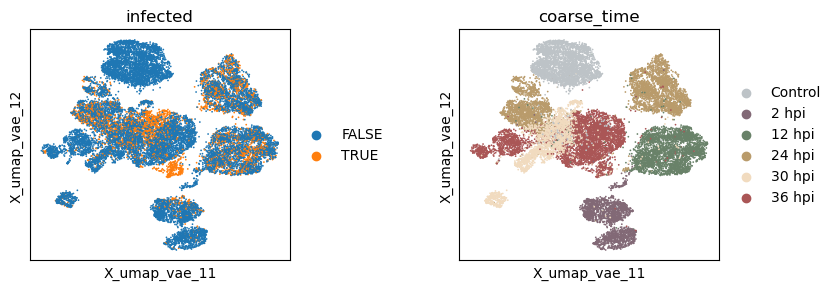

In [11]:
with plt.rc_context({"figure.figsize": (3, 3)}):
    sc.pl.embedding(adata, basis=f'X_umap_{_method}_1', color=['infected', 'coarse_time'], ncols=2, wspace = 0.5)

#### Evaluate the quality of learned subspace representations

Since we are only learning one subspace, there is no disentanglement as can be measured by the Grassmann distance.

In [12]:
_method = 'vae'

# subspace grassmann distance
np.linalg.norm(subspace_angles(adata.obsm[f'X_{_method}'], adata.obsm[f'X_{_method}']))

np.float32(8.7100825e-06)

To measure the information richness of the learned subspace, we use the silhouette score where a high value indicates that the target information is well-presented in the corresponding subspace. From the results we see that the unsupervised VAE embedding mostly captures the temporal dynamics rather than the infection status.

In [13]:
_method = 'vae'

# raw embeddings
f1 = silhouette_score(
    adata.obsm[f'X_{_method}'], 
    y_infected.squeeze()
)
f2 = silhouette_score(
    adata.obsm[f'X_{_method}'], 
    y_time.squeeze()
)

print(f"Information density - Silhouette - (infection, time): ({f1:.3f}, {f2:.3f})")

# UMAP embeddings
f3 = silhouette_score(
    adata.obsm[f'X_umap_{_method}_1'], 
    y_infected.squeeze()
)
f4 = silhouette_score(
    adata.obsm[f'X_umap_{_method}_1'], 
    y_time.squeeze()
)

print(f"Information density after UMAP - Silhouette - (infection, time): ({f3:.3f}, {f4:.3f})")


Information density - Silhouette - (infection, time): (0.042, 0.137)
Information density after UMAP - Silhouette - (infection, time): (-0.036, 0.296)


### Run supervised VAE (with prediction objective, no HSIC regularization)

Next, we consider the supervised VAE (`supVAE`) model where, similar to `sPCA`, supervision is added to guide the learning of the latent subspace. Here, we will use the infection status and the post-infection time point as targets.

In [14]:
# specify the configuration
target_supervision_list = [
    SupervisionAnnData(target_key = 'infected', field_type = 'obs', target_type = 'categorical', target_n_dim = 2),
    SupervisionAnnData(target_key = 'coarse_time', field_type = 'obs', target_type = 'categorical', target_n_dim = 6),
]
n_latent_sub = [10, 10]
predict_target_from_latent_sub = True
hsic_scale = 0

seed_everything(42, workers=True)

# initialize the model
HCVI.setup_anndata(adata, layer = 'logcounts', target_supervision_list = target_supervision_list)
supvae = HCVI(
    adata, 
    hsic_scale=hsic_scale,
    n_latent_sub=n_latent_sub, 
    predict_target_from_latent_sub=predict_target_from_latent_sub,
    target_supervision_list=target_supervision_list,
)

Seed set to 42
/Users/jysumac/miniforge3/envs/sispca/lib/python3.10/site-packages/scvi/data/fields/_base_field.py:63: UserWarning: adata.layers[logcounts] does not contain unnormalized count data. Are you sure this is what you want?
/Users/jysumac/Projects/sispca/sispca/hcv_vi.py:89: UserWarning: Removing redundant argument 'n_latent=20'.
/Users/jysumac/Projects/sispca/sispca/hcv_vi.py:89: UserWarning: Removing redundant argument 'latent_distribution=normal'.
/Users/jysumac/Projects/sispca/sispca/hcv_vi.py:89: UserWarning: Removing redundant argument 'dispersion=gene'.


In [15]:
supvae

HCVI model with the following parameters: 
------------------------------------------
*(architecture): n_layers = 1, dropout_rate = 0.1, gene_likelihood = normal
*(subspace) n_subspace = 2, n_latent_sub = [10, 10], hsic_scale = 0
*(supervision) predict_target = True, n_target = 2
Training status: Not Trained
Model's adata is minified?: False

#### Model fitting

In [16]:
supvae.train(max_epochs=100)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/jysumac/miniforge3/envs/sispca/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: PossibleUserWarning: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/jysumac/miniforge3/envs/sispca/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: PossibleUserWarning: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


We again check the convergence of the model by plotting the training loss. Note the prediction loss and the reconstruction loss have equal weights, as in the original HCV paper. 

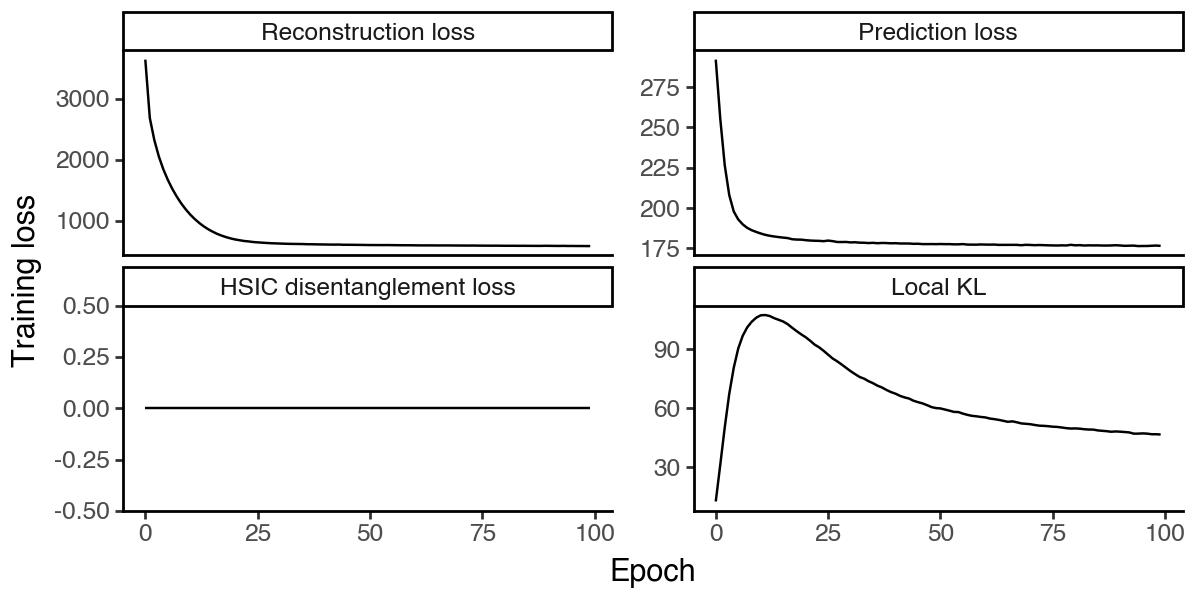

In [17]:
df_loss = pd.DataFrame(
    {k:supvae.history[k].values.squeeze().astype(float)
     for k in ['reconstruction_loss_train', 'kl_local_train', 'kl_global_train', 'prediction_loss_sum_train']}
).reset_index(names='epoch')

df_loss = df_loss.melt(id_vars='epoch', var_name='loss_type', value_name='loss')
df_loss['loss_type'] = pd.Categorical(
    df_loss['loss_type'].map({
        'reconstruction_loss_train': 'Reconstruction loss',
        'kl_local_train': 'Local KL',
        'kl_global_train': 'HSIC disentanglement loss',
        'prediction_loss_sum_train': 'Prediction loss'
    }),
    categories=['Reconstruction loss', 'Prediction loss', 'HSIC disentanglement loss', 'Local KL'],
    ordered=True
)

(
    ggplot(df_loss, aes(x = 'epoch', y = 'loss', group = 'loss_type')) +
        facet_wrap('~loss_type', scales='free_y') +
        geom_line() +
        labs(x = 'Epoch', y = 'Training loss') +
        theme_classic() +
        theme(figure_size=(6, 3))
)

#### Visualize the latent spaces

Now let's extract the learned latent subspaces and use UMAP to visualize them.

In [18]:
_method = 'supvae'
adata.obsm[f'X_{_method}'] = supvae.get_latent_representation()

# add the latent representation to the adata object
_sub = np.split(adata.obsm[f'X_{_method}'], n_latent_sub[:-1], axis = -1)
for i in range(len(_sub)):
    adata.obsm[f'X_{_method}_{i+1}'] = _sub[i]

# project the latent subspaces to 2D using UMAP
for i in range(len(_sub)):
    sc.pp.neighbors(adata, use_rep=f"X_{_method}_{i+1}")
    sc.tl.umap(adata)
    adata.obsm[f'X_umap_{_method}_{i + 1}'] = adata.obsm['X_umap'].copy()

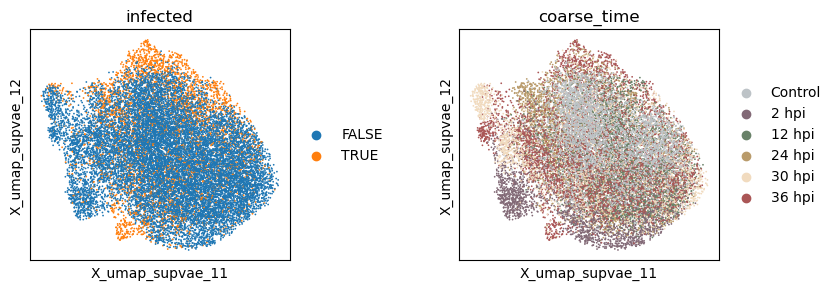

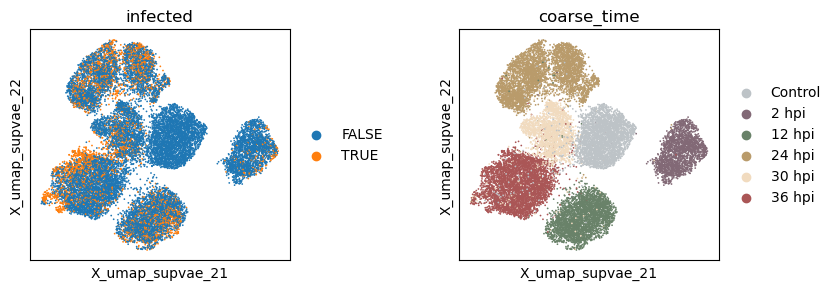

In [19]:
with plt.rc_context({"figure.figsize": (3, 3)}):
    sc.pl.embedding(adata, basis=f'X_umap_{_method}_1', color=['infected', 'coarse_time'], ncols=2, wspace = 0.5)
    sc.pl.embedding(adata, basis=f'X_umap_{_method}_2', color=['infected', 'coarse_time'], ncols=2, wspace = 0.5)

#### Evaluate the quality of learned subspace representations

In [20]:
_method = 'supvae'

# subspace grassmann distance
np.linalg.norm(subspace_angles(adata.obsm[f'X_{_method}_1'], adata.obsm[f'X_{_method}_2']))

np.float32(3.571018)

As expected, we see that supervision increases the relative information richness of the learned subspaces. However, the infection subspace still does not appear to capture much of the infection status information.

In [21]:
_method = 'supvae'

# raw embeddings
f1 = silhouette_score(
    adata.obsm[f'X_{_method}_1'], 
    y_infected.squeeze()
)
f2 = silhouette_score(
    adata.obsm[f'X_{_method}_2'], 
    y_time.squeeze()
)

print(f"Information density - Silhouette - (infection, time): ({f1:.3f}, {f2:.3f})")

# UMAP embeddings
f3 = silhouette_score(
    adata.obsm[f'X_umap_{_method}_1'], 
    y_infected.squeeze()
)
f4 = silhouette_score(
    adata.obsm[f'X_umap_{_method}_2'], 
    y_time.squeeze()
)

print(f"Information density after UMAP - Silhouette - (infection, time): ({f3:.3f}, {f4:.3f})")


Information density - Silhouette - (infection, time): (0.073, 0.159)
Information density after UMAP - Silhouette - (infection, time): (0.041, 0.479)


### Run hsVAE (with prediction objective, with HSIC regularization)
Next, let's consider the full `hsVAE` model where, similar to `sisPCA`, we further add HSIC regularization to enforce independence between the latent subspaces. The HSIC loss is calculated using a Gaussian kernel as suggested in the HCV paper.

In [22]:
# specify the configuration
target_supervision_list = [
    SupervisionAnnData(target_key = 'infected', field_type = 'obs', target_type = 'categorical', target_n_dim = 2),
    SupervisionAnnData(target_key = 'coarse_time', field_type = 'obs', target_type = 'categorical', target_n_dim = 6),
]
n_latent_sub = [10, 10]
predict_target_from_latent_sub = True
hsic_scale = 100

seed_everything(42, workers=True)

# initialize the model
HCVI.setup_anndata(adata, layer = 'logcounts', target_supervision_list = target_supervision_list)
hsvae = HCVI(
    adata, 
    hsic_scale=hsic_scale,
    n_latent_sub=n_latent_sub, 
    predict_target_from_latent_sub=predict_target_from_latent_sub,
    target_supervision_list=target_supervision_list,
)

Seed set to 42
/Users/jysumac/miniforge3/envs/sispca/lib/python3.10/site-packages/scvi/data/fields/_base_field.py:63: UserWarning: adata.layers[logcounts] does not contain unnormalized count data. Are you sure this is what you want?
/Users/jysumac/Projects/sispca/sispca/hcv_vi.py:89: UserWarning: Removing redundant argument 'n_latent=20'.
/Users/jysumac/Projects/sispca/sispca/hcv_vi.py:89: UserWarning: Removing redundant argument 'latent_distribution=normal'.
/Users/jysumac/Projects/sispca/sispca/hcv_vi.py:89: UserWarning: Removing redundant argument 'dispersion=gene'.


In [23]:
hsvae

HCVI model with the following parameters: 
------------------------------------------
*(architecture): n_layers = 1, dropout_rate = 0.1, gene_likelihood = normal
*(subspace) n_subspace = 2, n_latent_sub = [10, 10], hsic_scale = 100
*(supervision) predict_target = True, n_target = 2
Training status: Not Trained
Model's adata is minified?: False

#### Model fitting

In [24]:
hsvae.train(max_epochs=100)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/jysumac/miniforge3/envs/sispca/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: PossibleUserWarning: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/jysumac/miniforge3/envs/sispca/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: PossibleUserWarning: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


First check the model convergence.

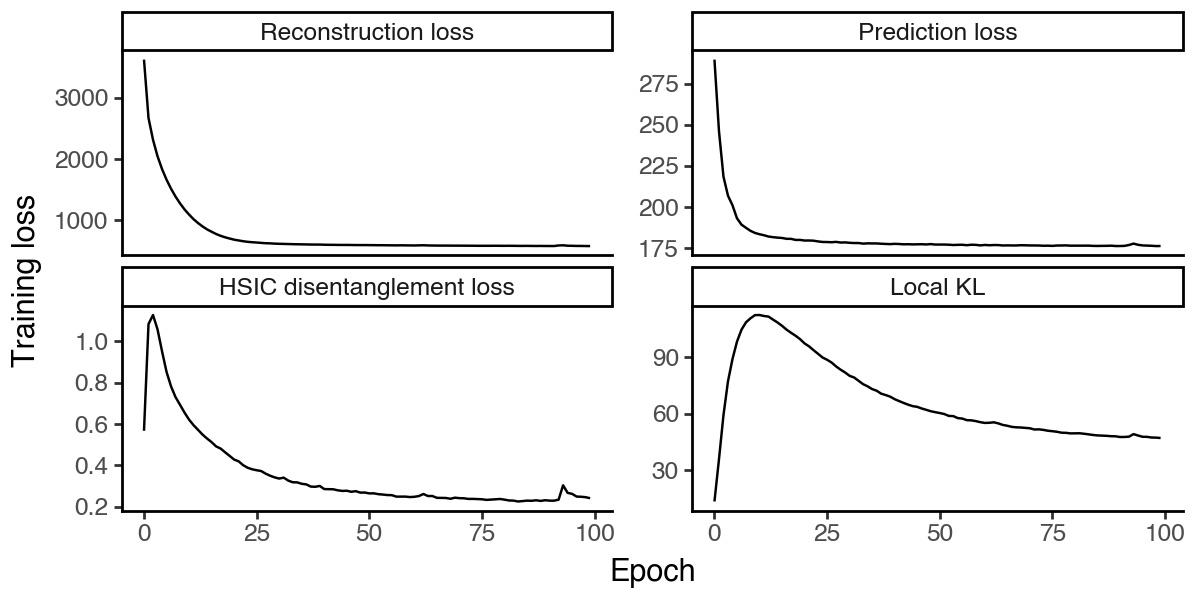

In [25]:
df_loss = pd.DataFrame(
    {k:hsvae.history[k].values.squeeze().astype(float)
     for k in ['reconstruction_loss_train', 'kl_local_train', 'kl_global_train', 'prediction_loss_sum_train']}
).reset_index(names='epoch')

df_loss = df_loss.melt(id_vars='epoch', var_name='loss_type', value_name='loss')
df_loss['loss_type'] = pd.Categorical(
    df_loss['loss_type'].map({
        'reconstruction_loss_train': 'Reconstruction loss',
        'kl_local_train': 'Local KL',
        'kl_global_train': 'HSIC disentanglement loss',
        'prediction_loss_sum_train': 'Prediction loss'
    }),
    categories=['Reconstruction loss', 'Prediction loss', 'HSIC disentanglement loss', 'Local KL'],
    ordered=True
)

(
    ggplot(df_loss, aes(x = 'epoch', y = 'loss', group = 'loss_type')) +
        facet_wrap('~loss_type', scales='free_y') +
        geom_line() +
        labs(x = 'Epoch', y = 'Training loss') +
        theme_classic() +
        theme(figure_size=(6, 3))
)

#### Visualize the latent spaces

Now let's extract the learned latent subspaces and use UMAP to visualize them.

In [26]:
_method = 'hsvae'
adata.obsm[f'X_{_method}'] = hsvae.get_latent_representation()

# add the latent representation to the adata object
_sub = np.split(adata.obsm[f'X_{_method}'], n_latent_sub[:-1], axis = -1)
for i in range(len(_sub)):
    adata.obsm[f'X_{_method}_{i+1}'] = _sub[i]

# project the latent subspaces to 2D using UMAP
for i in range(len(_sub)):
    sc.pp.neighbors(adata, use_rep=f"X_{_method}_{i+1}")
    sc.tl.umap(adata)
    adata.obsm[f'X_umap_{_method}_{i + 1}'] = adata.obsm['X_umap'].copy()

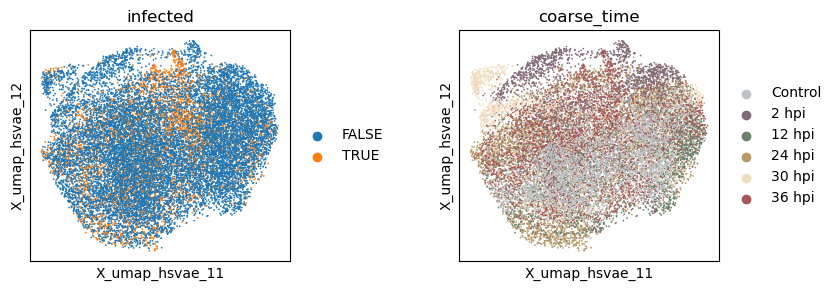

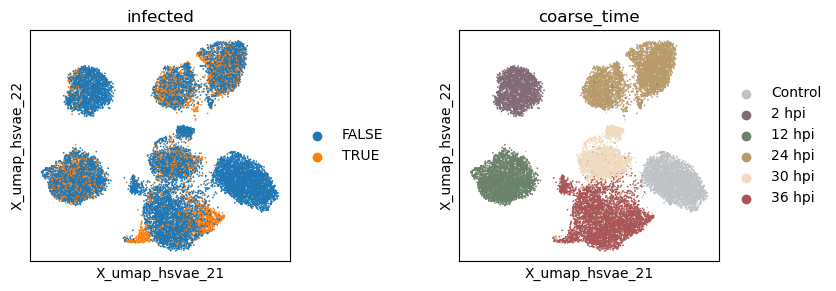

In [27]:
with plt.rc_context({"figure.figsize": (3, 3)}):
    sc.pl.embedding(adata, basis=f'X_umap_{_method}_1', color=['infected', 'coarse_time'], ncols=2, wspace = 0.5)
    sc.pl.embedding(adata, basis=f'X_umap_{_method}_2', color=['infected', 'coarse_time'], ncols=2, wspace = 0.5)

#### Evaluate the quality of learned subspace representations

The HSIC regularization increases the separation between the latent subspaces, as can be seen from the Grassmann distance. 

In [28]:
_method = 'hsvae'

# subspace grassmann distance
np.linalg.norm(subspace_angles(adata.obsm[f'X_{_method}_1'], adata.obsm[f'X_{_method}_2']))

np.float32(3.5977325)

However, the disentanglement does not help much in enhancing signal intensity in the infection subspace, suggesting an underperformance of the VAE-based models in general.

In [29]:
_method = 'hsvae'

# raw embeddings
f1 = silhouette_score(
    adata.obsm[f'X_{_method}_1'], 
    y_infected.squeeze()
)
f2 = silhouette_score(
    adata.obsm[f'X_{_method}_2'], 
    y_time.squeeze()
)

print(f"Information density - Silhouette - (infection, time): ({f1:.3f}, {f2:.3f})")

# UMAP embeddings
f3 = silhouette_score(
    adata.obsm[f'X_umap_{_method}_1'], 
    y_infected.squeeze()
)
f4 = silhouette_score(
    adata.obsm[f'X_umap_{_method}_2'], 
    y_time.squeeze()
)

print(f"Information density after UMAP - Silhouette - (infection, time): ({f3:.3f}, {f4:.3f})")


Information density - Silhouette - (infection, time): (0.059, 0.217)
Information density after UMAP - Silhouette - (infection, time): (-0.015, 0.582)


### Run hsVAE-sc (hsVAE adapted for scRNA-seq data)

Finally, to test the general limits of non-linear VAE models and see if we can further improve the performance, we introduce several domain-specific modifications to the `hsVAE` model. In particular, the `hsVAE-sc` model is designed solely to handle scRNA-seq data by using negative binomial as the data generative distribution, where the library size (total counts) per cell is modeled using an additional auto-encoder. Correspondingly, the `hsVAE-sc` model will be trained on counts-level data.

In [30]:
# specify the configuration
target_supervision_list = [
    SupervisionAnnData(target_key = 'infected', field_type = 'obs', target_type = 'categorical', target_n_dim = 2),
    SupervisionAnnData(target_key = 'coarse_time', field_type = 'obs', target_type = 'categorical', target_n_dim = 6),
]
n_latent_sub = [10, 10]
predict_target_from_latent_sub = True
hsic_scale = 100

seed_everything(42, workers=True)

# initialize the model using counts-level data
HCVI.setup_anndata(adata, layer = 'counts', target_supervision_list = target_supervision_list)
hcv = HCVI(
    adata, 
    hsic_scale=hsic_scale,
    n_latent_sub=n_latent_sub, 
    predict_target_from_latent_sub=predict_target_from_latent_sub,
    target_supervision_list=target_supervision_list,
    gene_likelihood='nb' # Negative binomial for gene counts
)

Seed set to 42
/Users/jysumac/miniforge3/envs/sispca/lib/python3.10/site-packages/scvi/data/fields/_base_field.py:63: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
/Users/jysumac/Projects/sispca/sispca/hcv_vi.py:89: UserWarning: Removing redundant argument 'n_latent=20'.
/Users/jysumac/Projects/sispca/sispca/hcv_vi.py:89: UserWarning: Removing redundant argument 'latent_distribution=normal'.
/Users/jysumac/Projects/sispca/sispca/hcv_vi.py:89: UserWarning: Removing redundant argument 'dispersion=gene'.


In [31]:
hcv

HCVI model with the following parameters: 
------------------------------------------
*(architecture): n_layers = 1, dropout_rate = 0.1, gene_likelihood = nb
*(subspace) n_subspace = 2, n_latent_sub = [10, 10], hsic_scale = 100
*(supervision) predict_target = True, n_target = 2
Training status: Not Trained
Model's adata is minified?: False

#### Model fitting

The training of `hsVAE-sc` will be slower because of the extra parametrization.

In [32]:
hcv.train(max_epochs=100)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/jysumac/miniforge3/envs/sispca/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: PossibleUserWarning: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/jysumac/miniforge3/envs/sispca/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: PossibleUserWarning: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


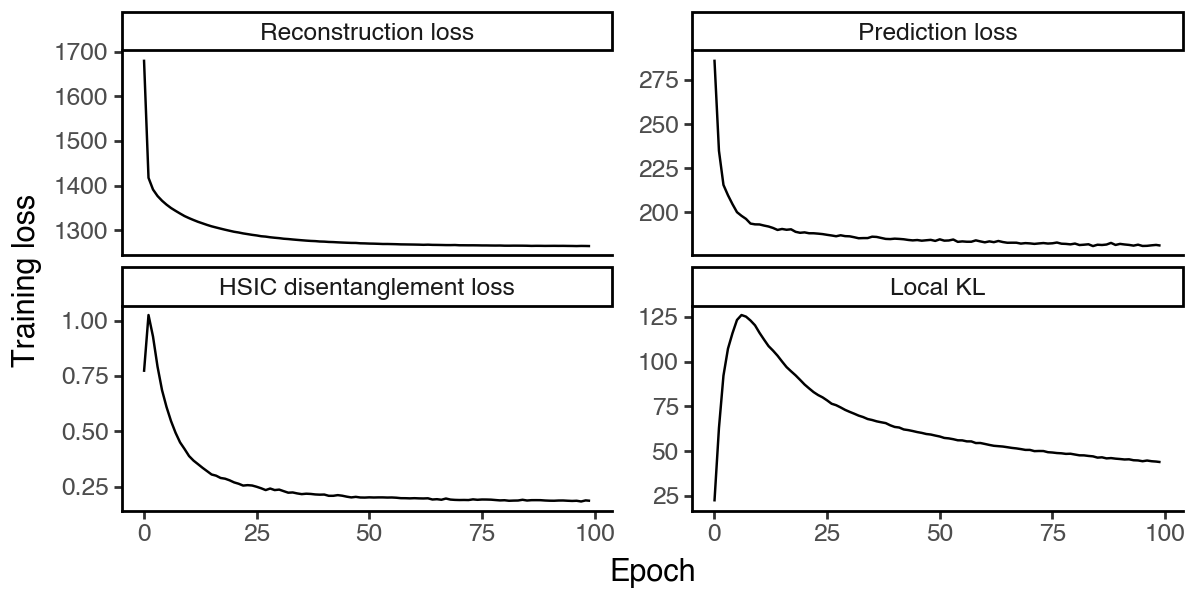

In [33]:
df_loss = pd.DataFrame(
    {k:hcv.history[k].values.squeeze().astype(float)
     for k in ['reconstruction_loss_train', 'kl_local_train', 'kl_global_train', 'prediction_loss_sum_train']}
).reset_index(names='epoch')

df_loss = df_loss.melt(id_vars='epoch', var_name='loss_type', value_name='loss')
df_loss['loss_type'] = pd.Categorical(
    df_loss['loss_type'].map({
        'reconstruction_loss_train': 'Reconstruction loss',
        'kl_local_train': 'Local KL',
        'kl_global_train': 'HSIC disentanglement loss',
        'prediction_loss_sum_train': 'Prediction loss'
    }),
    categories=['Reconstruction loss', 'Prediction loss', 'HSIC disentanglement loss', 'Local KL'],
    ordered=True
)

(
    ggplot(df_loss, aes(x = 'epoch', y = 'loss', group = 'loss_type')) +
        facet_wrap('~loss_type', scales='free_y') +
        geom_line() +
        labs(x = 'Epoch', y = 'Training loss') +
        theme_classic() +
        theme(figure_size=(6, 3))
)

#### Visualize the latent spaces

Now let's extract the learned latent subspaces and use UMAP to visualize them.

In [34]:
_method = 'hcv'
adata.obsm[f'X_{_method}'] = hcv.get_latent_representation()

# add the latent representation to the adata object
_sub = np.split(adata.obsm[f'X_{_method}'], n_latent_sub[:-1], axis = -1)
for i in range(len(_sub)):
    adata.obsm[f'X_{_method}_{i+1}'] = _sub[i]

# project the latent subspaces to 2D using UMAP
for i in range(len(_sub)):
    sc.pp.neighbors(adata, use_rep=f"X_{_method}_{i+1}")
    sc.tl.umap(adata)
    adata.obsm[f'X_umap_{_method}_{i + 1}'] = adata.obsm['X_umap'].copy()

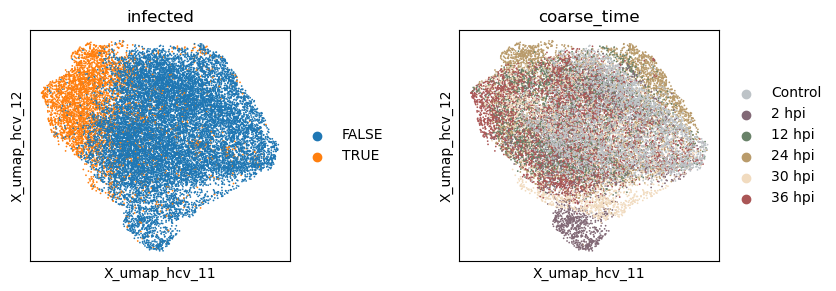

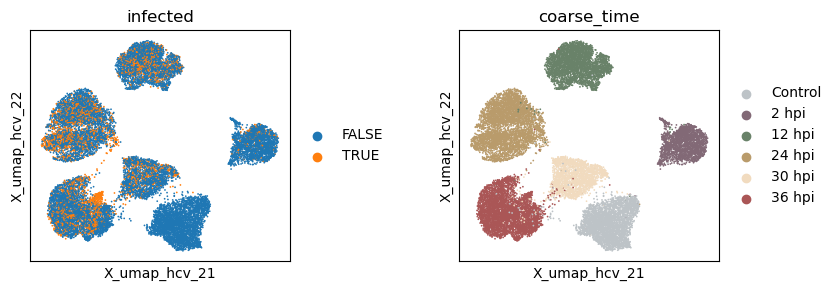

In [35]:
with plt.rc_context({"figure.figsize": (3, 3)}):
    sc.pl.embedding(adata, basis=f'X_umap_{_method}_1', color=['infected', 'coarse_time'], ncols=2, wspace = 0.5)
    sc.pl.embedding(adata, basis=f'X_umap_{_method}_2', color=['infected', 'coarse_time'], ncols=2, wspace = 0.5)

#### Evaluate the quality of learned subspace representations

In [36]:
_method = 'hcv'

# subspace grassmann distance
np.linalg.norm(subspace_angles(adata.obsm[f'X_{_method}_1'], adata.obsm[f'X_{_method}_2']))

np.float32(3.389588)

In [37]:
_method = 'hcv'
y_infected = adata.obs['infected'].cat.codes.to_numpy()[:, None]
y_time = adata.obs['coarse_time'].cat.codes.to_numpy()[:, None]

# raw embeddings
f1 = silhouette_score(
    adata.obsm[f'X_{_method}_1'], 
    y_infected.squeeze()
)
f2 = silhouette_score(
    adata.obsm[f'X_{_method}_2'], 
    y_time.squeeze()
)

print(f"Information density - Silhouette - (infection, time): ({f1:.3f}, {f2:.3f})")

# UMAP embeddings
f3 = silhouette_score(
    adata.obsm[f'X_umap_{_method}_1'], 
    y_infected.squeeze()
)
f4 = silhouette_score(
    adata.obsm[f'X_umap_{_method}_2'], 
    y_time.squeeze()
)

print(f"Information density after UMAP - Silhouette - (infection, time): ({f3:.3f}, {f4:.3f})")

Information density - Silhouette - (infection, time): (0.190, 0.337)
Information density after UMAP - Silhouette - (infection, time): (0.233, 0.634)


### Conclusions

In this tutorial, we have applied four non-linear models, namely `VAE`, `supVAE`, `hsVAE`, and `hsVAE-sc`, to learn infection-related representations in the single-cell atlas of malaria liver stage. 

* While these models can well capture temporal dynamics, they generally underperform in learning the infection status. This can be improved by introducing domain-specific knowledge such as better modeling for scRNA-seq counts data.
* As expected, introducing supervision via prediction heads can increase the information density in the relevant subspaces.
* HSIC regularization can improve subspace disentanglement, however it may come at the cost of weakening supervision.

Most importantly, in the absence of direct feature-subspace mapping, VAE-based models are not directly interpretable. This presents a major challenge for downstream biological analysis, as we will not be able to extract genes that contribute most to each subspace as did with `sisPCA` (Part I).

#### Save and reload the resulting anndata with subspace representations

In [38]:
res_dir = '/Users/jysumac/Projects/CancerAging/results/liver/'
date = '1014'

adata.write_h5ad(f"{res_dir}/2k_vae_repr_{date}.h5ad")

In [39]:
res_dir = '/Users/jysumac/Projects/CancerAging/results/liver/'
date = '1014'

adata = sc.read_h5ad(f"{res_dir}/2k_vae_repr_{date}.h5ad")

#### Visualize all VAE embeddings

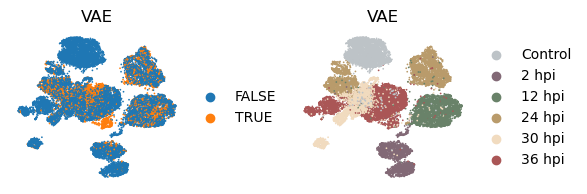

In [40]:
_method = 'vae'
with plt.rc_context({"figure.figsize": (2, 2)}):
    sc.pl.embedding(
        adata, basis=f'X_umap_{_method}_1', 
        color=['infected', 'coarse_time'], 
        title = ['VAE', 'VAE'],
        ncols=2, wspace = 0.5, frameon=False
    )

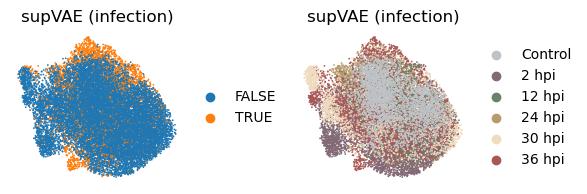

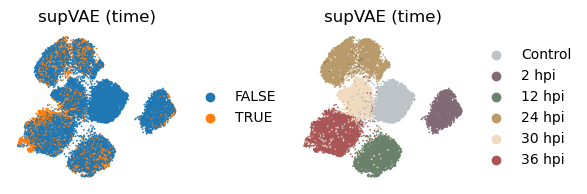

In [43]:
_method = 'supvae'
with plt.rc_context({"figure.figsize": (2, 2)}):
    sc.pl.embedding(
        adata, basis=f'X_umap_{_method}_1', 
        color=['infected', 'coarse_time'], 
        title = ['supVAE (infection)', 'supVAE (infection)'],
        ncols=2, wspace = 0.5, frameon=False
    )
    sc.pl.embedding(
        adata, basis=f'X_umap_{_method}_2', 
        color=['infected', 'coarse_time'], 
        title = ['supVAE (time)', 'supVAE (time)'],
        ncols=2, wspace = 0.5, frameon=False
    )

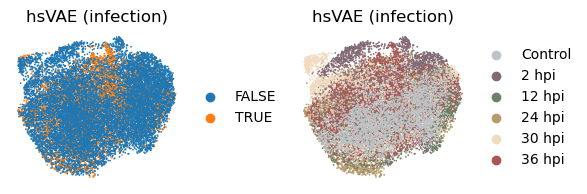

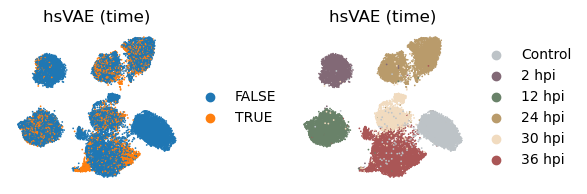

In [44]:
_method = 'hsvae'
with plt.rc_context({"figure.figsize": (2, 2)}):
    sc.pl.embedding(
        adata, basis=f'X_umap_{_method}_1', 
        color=['infected', 'coarse_time'], 
        title = ['hsVAE (infection)', 'hsVAE (infection)'],
        ncols=2, wspace = 0.5, frameon=False
    )
    sc.pl.embedding(
        adata, basis=f'X_umap_{_method}_2', 
        color=['infected', 'coarse_time'], 
        title = ['hsVAE (time)', 'hsVAE (time)'],
        ncols=2, wspace = 0.5, frameon=False
    )

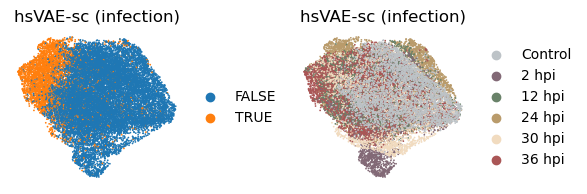

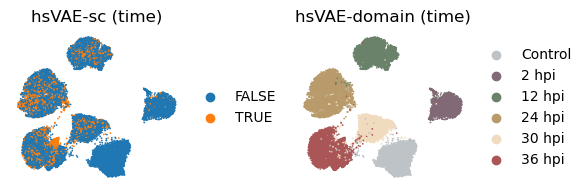

In [45]:
_method = 'hcv'
with plt.rc_context({"figure.figsize": (2, 2)}):
    sc.pl.embedding(
        adata, basis=f'X_umap_{_method}_1', 
        color=['infected', 'coarse_time'], 
        title = ['hsVAE-sc (infection)', 'hsVAE-sc (infection)'],
        ncols=2, wspace = 0.5, frameon=False
    )
    sc.pl.embedding(
        adata, basis=f'X_umap_{_method}_2', 
        color=['infected', 'coarse_time'], 
        title = ['hsVAE-sc (time)', 'hsVAE-domain (time)'],
        ncols=2, wspace = 0.5, frameon=False
    )